**Jupiter file used to create range prediction models**

**Imports**

In [ ]:
# Imports
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_absolute_error, mean_pinball_loss, make_scorer
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import RidgeCV, LassoCV
import statsmodels.api as sm
from statsmodels.api import OLS, add_constant
from xgboost import XGBRegressor
import ipywidgets as w
from collections import OrderedDict
import yfinance as yf
import warnings
import joblib


In [ ]:
# Load 1-min data
df_1m = pd.read_parquet(r"C:\Users\prath\Desktop\GridVision\5. Data\Core Data\ES_1Min(06.2015-07.2025).parquet")

# Ensure correct datetime index
df_1m["datetime"] = pd.to_datetime(df_1m["datetime"])
df_1m.set_index("datetime", inplace=True)
df_1m = df_1m.sort_index()

# Keep only required columns
ohlc_cols = ["open", "high", "low", "close", "volume"]
df_1m = df_1m[ohlc_cols]

# 4-Hour Resample (aligned to 22, 2, 6, ..., 18)
# Use offset = '2H' to shift the grouping
df_4h = df_1m.resample("4h", offset="2h").agg({
    "open": "first",
    "high": "max",
    "low": "min",
    "close": "last",
    "volume": "sum"
})
df_4h.dropna(inplace=True)

# 1-Hour Resample 
df_1h = df_1m.resample("1h").agg({
    "open": "first",
    "high": "max",
    "low": "min",
    "close": "last",
    "volume": "sum"
})
df_1h.dropna(inplace=True)

# Preview result
print("4H resampled:")
print(df_4h.tail())

print("\n1H resampled:")
print(df_1h.tail())


4H resampled:
                              open     high      low    close    volume
datetime                                                               
2025-07-29 02:00:00-04:00  6433.00  6440.75  6428.75  6440.00   46063.0
2025-07-29 06:00:00-04:00  6440.00  6442.50  6425.50  6432.75  165138.0
2025-07-29 10:00:00-04:00  6433.00  6434.50  6400.00  6409.00  556535.0
2025-07-29 14:00:00-04:00  6409.25  6411.75  6396.25  6403.50  301120.0
2025-07-29 18:00:00-04:00  6404.00  6414.00  6403.25  6412.25   37816.0

1H resampled:
                              open     high      low    close   volume
datetime                                                              
2025-07-29 16:00:00-04:00  6406.25  6407.25  6402.00  6403.50  36508.0
2025-07-29 18:00:00-04:00  6404.00  6409.25  6403.25  6407.50  10751.0
2025-07-29 19:00:00-04:00  6407.75  6409.50  6405.75  6407.75   8063.0
2025-07-29 20:00:00-04:00  6407.75  6413.00  6407.00  6412.00   9804.0
2025-07-29 21:00:00-04:00  6412.00  6414.

**Features**

In [7]:
# Core Features
df_4h["range"] = df_4h["high"] - df_4h["low"]
df_1h["range"] = df_1h["high"] - df_1h["low"]

df_4h["side"] = (df_4h["close"] >= df_4h["open"]).astype(int)
df_1h["side"] = (df_1h["close"] >= df_1h["open"]).astype(int)
df_4h["dayofweek"] = df_4h.index.dayofweek
df_1h["dayofweek"] = df_1h.index.dayofweek

# Session Mapping
# Sessions have distinct personalities, driven by different market participants. Mapping them could reveal time-dependent behavior.
def map_session(dt):
    hour = dt.hour
    if 2 <= hour < 6:
        return "London"
    elif 6 <= hour < 10:
        return "Pmkt"
    elif 10 <= hour < 14:
        return "Core"
    elif 14 <= hour < 18:
        return "Close"
    elif 18 <= hour < 22:
        return "Eve"
    else:
        return "Asia"


df_4h["session"] = df_4h.index.map(map_session)
df_1h["session"] = df_1h.index.hour

# Stochastic Oscillator
# Positions the close within a recent high-low range. Fear and greed often distort behavior near extremes, allowing us to map sentiment-inflected price zones.
low4h = df_4h["low"].rolling(11).min()
high4h = df_4h["high"].rolling(11).max()
df_4h["stoch_k"] = 100 * (df_4h["close"] - low4h) / (high4h - low4h)

low1h = df_1h["low"].rolling(11).min()
high1h = df_1h["high"].rolling(11).max()
df_1h["stoch_k"] = 100 * (df_1h["close"] - low1h) / (high1h - low1h)

# Candle Pattern Classification
# Classifies each candle by how its range and close relate to the previous bar, capturing structural setups like inside bars, breakouts, and exhaustion.
def classify_candle(df):
    prev = df.shift(1)

    h, l, o, c = df["high"], df["low"], df["open"], df["close"]
    hp, lp = prev["high"], prev["low"]

    pattern = pd.Series(index=df.index, dtype="object")

    # Logic replication
    pattern[(h > hp) & (l < lp) & (c > o)] = "purple"
    pattern[(h > hp) & (l < lp) & (c <= o)] = "maroon"

    pattern[(h > hp) & (l >= lp) & (c > o)] = "green"
    pattern[(h > hp) & (l >= lp) & (c <= o)] = "yellow"

    pattern[(h <= hp) & (l < lp) & (c > o)] = "blue"
    pattern[(h <= hp) & (l < lp) & (c <= o)] = "red"

    pattern[(h <= hp) & (l >= lp)] = "gray"

    pattern.fillna("unknown", inplace=True)

    df["pattern"] = pattern
    df.loc[df.index[0], "pattern"] = None  # No pattern on first row
    return df

df_4h = classify_candle(df_4h)
df_1h = classify_candle(df_1h)

df_4h = df_4h[df_4h["pattern"].notna() & (df_4h["range"] > 0)].copy() 
df_1h = df_1h[df_1h["pattern"].notna() & (df_1h["range"] > 0)].copy() 
print(df_4h.head())
print(df_1h.tail())


                              open     high      low    close    volume  \
datetime                                                                  
2015-06-28 22:00:00-04:00  2067.50  2070.50  2045.00  2066.75   53829.0   
2015-06-29 02:00:00-04:00  2066.75  2078.75  2057.00  2073.75  139621.0   
2015-06-29 06:00:00-04:00  2073.50  2083.25  2060.00  2077.75  408870.0   
2015-06-29 10:00:00-04:00  2070.00  2081.00  2051.25  2062.75  777109.0   
2015-06-29 14:00:00-04:00  2062.75  2063.00  2036.50  2052.75  682424.0   

                           range  side  dayofweek session  stoch_k pattern  
datetime                                                                    
2015-06-28 22:00:00-04:00  25.50     0          6    Asia      NaN  maroon  
2015-06-29 02:00:00-04:00  21.75     1          0  London      NaN   green  
2015-06-29 06:00:00-04:00  23.25     1          0    Pmkt      NaN   green  
2015-06-29 10:00:00-04:00  29.75     0          0    Core      NaN     red  
2015-06-29 1

**First 5-minute range feature Calculation**

In [ ]:
# Assign each 1-min row to its parent 4H candle
df_1m["parent_4h"] = (df_1m.index - pd.Timedelta(hours=2)).floor("4h") + pd.Timedelta(hours=2)
df_1m["parent_1h"] = df_1m.index.floor("1h")

# Calculate minutes elapsed from the start of the 4H candle
minutes_from_start_4h = (pd.Series(df_1m.index, index=df_1m.index) - df_1m["parent_4h"]).dt.total_seconds() // 60
minutes_from_start_1h = (pd.Series(df_1m.index, index=df_1m.index) - df_1m["parent_1h"]).dt.total_seconds() // 60

df_1m["within_first5_4h"] = minutes_from_start_4h < 5
df_1m["within_first5_1h"] = minutes_from_start_1h < 5

# Filter only the first 15 minutes of each 4H block
first5_4h_df = df_1m[df_1m["within_first5_4h"]]
first5_1h_df = df_1m[df_1m["within_first5_1h"]]

# Compute high-low range for the first 15 minutes
range_5min_4h = first5_4h_df.groupby("parent_4h").agg(
    high_15min=("high", "max"),
    low_15min=("low", "min")
)
range_5min_4h["range_5min"] = range_5min_4h["high_15min"] - range_5min_4h["low_15min"]


range_5min_1h = first5_1h_df.groupby("parent_1h").agg(
    high_5min=("high", "max"),
    low_5min=("low", "min")
)
range_5min_1h["range_5min"] = range_5min_1h["high_5min"] - range_5min_1h["low_5min"]



# Join to 4H DataFrame (ensure index compatibility)
df_4h = df_4h.join(range_5min_4h["range_5min"], how="left")
df_1h = df_1h.join(range_5min_1h["range_5min"], how="left")

print(df_4h.head())
print(df_1h.head())



                              open     high      low    close    volume  \
datetime                                                                  
2015-06-28 22:00:00-04:00  2067.50  2070.50  2045.00  2066.75   53829.0   
2015-06-29 02:00:00-04:00  2066.75  2078.75  2057.00  2073.75  139621.0   
2015-06-29 06:00:00-04:00  2073.50  2083.25  2060.00  2077.75  408870.0   
2015-06-29 10:00:00-04:00  2070.00  2081.00  2051.25  2062.75  777109.0   
2015-06-29 14:00:00-04:00  2062.75  2063.00  2036.50  2052.75  682424.0   

                           range  side  dayofweek session  stoch_k pattern  \
datetime                                                                     
2015-06-28 22:00:00-04:00  25.50     0          6    Asia      NaN  maroon   
2015-06-29 02:00:00-04:00  21.75     1          0  London      NaN   green   
2015-06-29 06:00:00-04:00  23.25     1          0    Pmkt      NaN   green   
2015-06-29 10:00:00-04:00  29.75     0          0    Core      NaN     red   
2015-0

In [9]:
# Convert categorical features into numeric form for model compatibility 
df_OHE_4h = df_4h.copy()
df_OHE_4h = df_OHE_4h.drop(columns=["session", "pattern", "dayofweek"])
df_OHE_4h = df_OHE_4h.join([
    pd.get_dummies(df_4h["session"], prefix="sess", dtype=float, drop_first=True),
    pd.get_dummies(df_4h["pattern"], prefix="pat", dtype=float, drop_first=True),
    pd.get_dummies(df_4h["dayofweek"], prefix="dow", dtype=float, drop_first=True),
])

print(df_OHE_4h.head())



# Convert categorical features into numeric form for model compatibility 
df_OHE_1h = df_1h.copy()
df_OHE_1h = df_OHE_1h.drop(columns=["session", "pattern", "dayofweek"])
df_OHE_1h = df_OHE_1h.join([
    pd.get_dummies(df_1h["session"], prefix="sess", dtype=float, drop_first=True),
    pd.get_dummies(df_1h["pattern"], prefix="pat", dtype=float, drop_first=True),
    pd.get_dummies(df_1h["dayofweek"], prefix="dow", dtype=float, drop_first=True),
])

print(df_OHE_1h.head())



                              open     high      low    close    volume  \
datetime                                                                  
2015-06-28 22:00:00-04:00  2067.50  2070.50  2045.00  2066.75   53829.0   
2015-06-29 02:00:00-04:00  2066.75  2078.75  2057.00  2073.75  139621.0   
2015-06-29 06:00:00-04:00  2073.50  2083.25  2060.00  2077.75  408870.0   
2015-06-29 10:00:00-04:00  2070.00  2081.00  2051.25  2062.75  777109.0   
2015-06-29 14:00:00-04:00  2062.75  2063.00  2036.50  2052.75  682424.0   

                           range  side  stoch_k  range_5min  sess_Close  ...  \
datetime                                                                 ...   
2015-06-28 22:00:00-04:00  25.50     0      NaN        0.75         0.0  ...   
2015-06-29 02:00:00-04:00  21.75     1      NaN        2.50         0.0  ...   
2015-06-29 06:00:00-04:00  23.25     1      NaN        8.75         0.0  ...   
2015-06-29 10:00:00-04:00  29.75     0      NaN        9.75         0.0  .

**Lagged Features**

In [10]:
# Flag strong candles where the body is large relative to the range — a sign of momentum that may impact the next bar
df_OHE_4h["is_strong_candle"] = ((df_4h["close"] - df_4h["open"]).abs() > 0.7 * df_4h["range"]).astype(int).shift(1)
df_OHE_1h["is_strong_candle"] = ((df_1h["close"] - df_1h["open"]).abs() > 0.7 * df_1h["range"]).astype(int).shift(1)

# Add lagged features for range and side to give the model short-term memory and help it learn from recent volatility and direction
for k in range(1, 6):
    df_OHE_4h[f"range_m{k}"] = df_OHE_4h["range"].shift(k)
    df_OHE_4h[f"side_m{k}"] = df_OHE_4h["side"].shift(k)

# Add lagged features for range and side to give the model short-term memory and help it learn from recent volatility and direction
for k in range(1, 6):
    df_OHE_1h[f"range_m{k}"] = df_OHE_1h["range"].shift(k)
    df_OHE_1h[f"side_m{k}"] = df_OHE_1h["side"].shift(k)

# Add lagged versions of each candle pattern 
for k in (1, 2, 3):
    for col in [c for c in df_OHE_4h.columns if c.startswith("pat_") and "_m" not in c]:
        df_OHE_4h[f"{col}_m{k}"] = df_OHE_4h[col].shift(k)

# Add lagged versions of each candle pattern 
for k in (1, 2, 3):
    for col in [c for c in df_OHE_1h.columns if c.startswith("pat_") and "_m" not in c]:
        df_OHE_1h[f"{col}_m{k}"] = df_OHE_1h[col].shift(k)
        
# Shift the stochastic oscillator forward so it's aligned as a predictive input, preventing look-ahead bias
df_OHE_4h["stoch_k"] = df_OHE_4h["stoch_k"].shift(1)
df_OHE_1h["stoch_k"] = df_OHE_1h["stoch_k"].shift(1)

df_OHE_1h = df_OHE_1h.dropna()
df_OHE_4h = df_OHE_4h.dropna()


**Train/Test Data**

In [11]:
def prepare_model_data(df, time_label="4h"):
    # 1) Filter to recent window
    df_small = df[df.index >= pd.Timestamp("2021-01-01", tz="America/New_York")].copy()

    # 2) Chronological split
    train_cutoff = pd.Timestamp("2024-01-01", tz="America/New_York")
    train = df_small[df_small.index < train_cutoff].copy()
    test  = df_small[df_small.index >= train_cutoff].copy()

    # 3) Remove extreme outliers on TRAIN ONLY (no touching test)
    q95 = train["range"].quantile(0.97)
    train = train[train["range"] <= q95].copy()
    test  = test[test["range"] <= q95].copy()   #uncomment when runnning for model download. Comment for test. 
    
    # Step 4: Feature selection
    core_feats     = [f"range_m{k}" for k in range(1, 6)] + [f"side_m{k}" for k in range(1, 6)]
    lag_pat_cols   = [c for c in df.columns if c.startswith("pat_") and "_m" in c]
    sess_cols      = [c for c in df.columns if c.startswith("sess_")]
    dow_cols       = [c for c in df.columns if c.startswith("dow_")]

    features = core_feats + sess_cols + dow_cols + lag_pat_cols + ["is_strong_candle", "range_5min"]

    # Step 5: Return final input/output sets
    X_train = train[features]
    y_train = train["range"]
    X_test  = test[features]
    y_test  = test["range"]

    print(f"{time_label.upper()}  — Train shape: {X_train.shape}, Test shape: {X_test.shape}")
    return X_train, X_test, y_train, y_test

# Run for both 4H and 1H
X_train_4h, X_test_4h, y_train_4h, y_test_4h = prepare_model_data(df_OHE_4h, time_label="4h")
X_train_1h, X_test_1h, y_train_1h, y_test_1h = prepare_model_data(df_OHE_1h, time_label="1h")


4H  — Train shape: (2946, 38), Test shape: (1439, 38)
1H  — Train shape: (17192, 56), Test shape: (8623, 56)


**Export Models for Live**

In [ ]:
import statsmodels.api as sm
import joblib
import pandas as pd

'''
class HuberWrapper:
    def __init__(self):
        self.model = None
        self.feature_names = None

    def fit(self, X, y):
        Xc = sm.add_constant(X)
        # Huber (RLM) with default tuning; you can tweak 'M' or 'scale_est'
        self.model = sm.RLM(y, Xc, M=sm.robust.norms.HuberT()).fit()
        self.feature_names = X.columns.tolist()

    def predict(self, X_new):
        X_new = X_new[self.feature_names].copy()
        Xc = sm.add_constant(X_new, has_constant='add')
        return self.model.predict(Xc)

    def summary(self):
        return self.model.summary()
        '''

from huber_wrapper import HuberWrapper

# ==== Fit on ALL (train + test) for LIVE use 
X_full_4h = pd.concat([X_train_4h, X_test_4h]).sort_index()
y_full_4h = pd.concat([y_train_4h, y_test_4h]).loc[X_full_4h.index]

X_full_1h = pd.concat([X_train_1h, X_test_1h]).sort_index()
y_full_1h = pd.concat([y_train_1h, y_test_1h]).loc[X_full_1h.index]

huber_4h = HuberWrapper()
huber_4h.fit(X_full_4h, y_full_4h)

huber_1h = HuberWrapper()
huber_1h.fit(X_full_1h, y_full_1h)

joblib.dump(huber_4h, "huber_4h_2025-08-04.pkl")
joblib.dump(huber_1h, "huber_1h_2025-08-04.pkl")


class OLSWrapper:
    def __init__(self):
        self.model = None
        self.feature_names = None

    def fit(self, X, y):
        X_const = sm.add_constant(X)
        self.model = sm.OLS(y, X_const).fit()
        self.feature_names = X.columns.tolist()

    def predict(self, X_new):
        X_new = X_new[self.feature_names].copy()
        X_const = sm.add_constant(X_new, has_constant='add')
        return self.model.predict(X_const)

    def summary(self):
        return self.model.summary()

# ==== Fit on ALL (train + test) for LIVE use ====
X_full_4h = pd.concat([X_train_4h, X_test_4h]).sort_index()
y_full_4h = pd.concat([y_train_4h, y_test_4h]).loc[X_full_4h.index]

X_full_1h = pd.concat([X_train_1h, X_test_1h]).sort_index()
y_full_1h = pd.concat([y_train_1h, y_test_1h]).loc[X_full_1h.index]

ols_4h = OLSWrapper()
ols_4h.fit(X_full_4h, y_full_4h)

ols_1h = OLSWrapper()
ols_1h.fit(X_full_1h, y_full_1h)

# ==== Save to disk ====
joblib.dump(ols_4h, "ols_4h_2025-08-04.pkl")
joblib.dump(ols_1h, "ols_1h_2025-08-04.pkl")


['ols_1h_2025-08-04.pkl']

**Linear Models**


====== 4H MODELS ======
                            OLS Regression Results                            
Dep. Variable:                  range   R-squared:                       0.615
Model:                            OLS   Adj. R-squared:                  0.610
Method:                 Least Squares   F-statistic:                     122.2
Date:                Thu, 14 Aug 2025   Prob (F-statistic):               0.00
Time:                        15:09:26   Log-Likelihood:                -10335.
No. Observations:                2946   AIC:                         2.075e+04
Df Residuals:                    2907   BIC:                         2.098e+04
Df Model:                          38                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const          

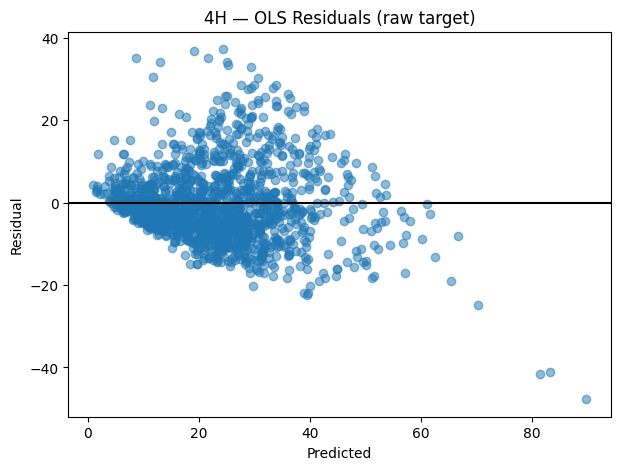


====== 1H MODELS ======
                            OLS Regression Results                            
Dep. Variable:                  range   R-squared:                       0.672
Model:                            OLS   Adj. R-squared:                  0.670
Method:                 Least Squares   F-statistic:                     637.0
Date:                Thu, 14 Aug 2025   Prob (F-statistic):               0.00
Time:                        15:09:28   Log-Likelihood:                -49124.
No. Observations:               17192   AIC:                         9.836e+04
Df Residuals:                   17136   BIC:                         9.879e+04
Df Model:                          55                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const          

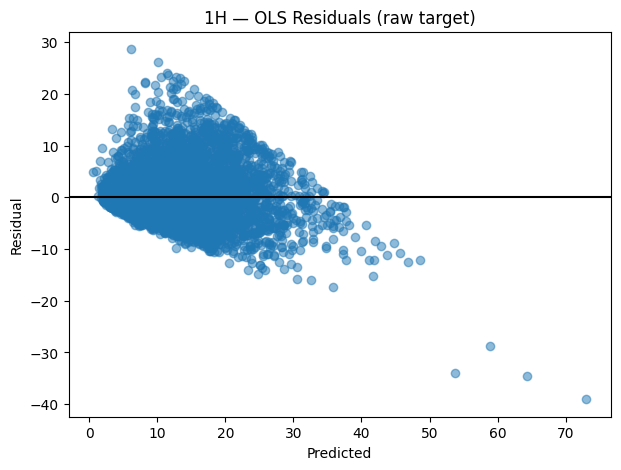

In [13]:
def run_linear_models(X_train, X_test, y_train, y_test, label="4h"):
    print(f"\n====== {label.upper()} MODELS ======")

    # OLS
    ols_model = sm.OLS(y_train, sm.add_constant(X_train)).fit()
    ols_pred = ols_model.predict(sm.add_constant(X_test))
    mae_ols = mean_absolute_error(y_test, ols_pred)

    # Ridge
    ridge = RidgeCV(alphas=[0.1, 1.0, 10.0]).fit(X_train, y_train)
    mae_ridge = mean_absolute_error(y_test, ridge.predict(X_test))

    # Lasso
    lasso = LassoCV(cv=5).fit(X_train, y_train)
    mae_lasso = mean_absolute_error(y_test, lasso.predict(X_test))

    # Huber
    huber = sm.RLM(y_train, sm.add_constant(X_train), M=sm.robust.norms.HuberT()).fit()
    huber_pred = huber.predict(sm.add_constant(X_test))
    mae_huber = mean_absolute_error(y_test, huber_pred)

    # Summary + MAEs
    print(ols_model.summary())
    print("Linear Model MAEs:")
    print(f"OLS MAE         : {mae_ols:.2f} pts")
    print(f"Ridge MAE       : {mae_ridge:.2f} pts")
    print(f"Lasso MAE       : {mae_lasso:.2f} pts")
    print(f"Huber MAE       : {mae_huber:.2f} pts")

    # Residual Plot
    plt.figure(figsize=(7, 5))
    plt.scatter(ols_pred, y_test - ols_pred, alpha=0.5)
    plt.axhline(0, color="k")
    plt.xlabel("Predicted")
    plt.ylabel("Residual")
    plt.title(f"{label.upper()} — OLS Residuals (raw target)")
    plt.show()


# Run for both 4H and 1H
run_linear_models(X_train_4h, X_test_4h, y_train_4h, y_test_4h, label="4h")
run_linear_models(X_train_1h, X_test_1h, y_train_1h, y_test_1h, label="1h")


**Random Forest**

In [14]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

def run_rf(X_train, y_train, X_test, y_test, label="4h"):
    """Train RF, report MAE, and return fitted model & predictions."""
    rf = RandomForestRegressor(
        n_estimators=333,
        max_depth=None,          # let the forest grow fully
        random_state=11,
        n_jobs=-1                # use all cores for speed
    )
    rf.fit(X_train, y_train)
    preds = rf.predict(X_test)
    mae   = mean_absolute_error(y_test, preds)
    print(f"{label.upper()} RF MAE:\t{mae:.2f} pts")
    return rf, preds, mae

# --- run for both horizons --------------------------------------------------
rf_4h,  rf_pred_4h,  mae_rf_4h  = run_rf(X_train_4h, y_train_4h, X_test_4h, y_test_4h, label="4h")
rf_1h,  rf_pred_1h,  mae_rf_1h  = run_rf(X_train_1h, y_train_1h, X_test_1h, y_test_1h, label="1h")


4H RF MAE:	6.93 pts
1H RF MAE:	3.08 pts


**Testing**

In [ ]:
import joblib

huber_4h_loaded = joblib.load("huber_4h_2025-08-04.pkl")
huber_1h_loaded = joblib.load("huber_1h_2025-08-04.pkl")


# Predict on the first row of your test set
row_4h = X_test_4h.iloc[[199]]
true_4h = y_test_4h.iloc[199]
pred_4h = huber_4h_loaded.predict(row_4h)


row_1h = X_test_1h.iloc[[199]]
true_1h = y_test_1h.iloc[199]
pred_1h = huber_1h_loaded.predict(row_1h)

print(f"Actual 4H range : {true_4h:.2f} pts")
print(f"Predicted 4H range: {pred_4h.iloc[0]:.2f} pts")

print(f"Actual 1H range : {true_1h:.2f} pts")
print(f"Predicted 1H range: {pred_1h.iloc[0]:.2f} pts")


Actual 4H range : 19.75 pts
Predicted 4H range: 19.67 pts
Actual 1H range : 23.50 pts
Predicted 1H range: 19.38 pts
